### Column Names and Data Types

| Column Name(s)                | Data Type   | Description                                 |
|-------------------------------|------------|---------------------------------------------|
| image_filename                | object     | Image file name                             |
| cell_number                   | int64      | Cell number in the image                    |
| cell_row                      | int64      | Row index of the cell                       |
| cell_col                      | int64      | Column index of the cell                    |
| label                         | int64      | Wildlife present (1) or not (0)             |
| c1-c64                        | float64    | Feature values (color, HOG, etc.)           |
| c65-c135                      | float64    | Additional feature values                   |

EDA step 1: Check for missing values

Reason for this step:
To identify any incomplete data that may affect analysis or model performance.

In [2]:
missing_summary = df.isnull().sum()
# Highlight columns with missing values
missing_cols = missing_summary[missing_summary > 0].sort_values(ascending=False)
if not missing_cols.empty:
    print("Columns with missing values:")
    display(missing_cols)
else:
    print("No missing values found in any column.")

Columns with missing values:


c122    8
c123    8
c30     8
c27     7
c33     7
c1      1
c5      1
c8      1
c14     1
c11     1
c18     1
c17     1
c16     1
c15     1
c58     1
c53     1
c79     1
c68     1
dtype: int64

In [3]:
# Impute missing values using median for all columns
df_imputed = df.copy()
df_imputed = df_imputed.fillna(df_imputed.median(numeric_only=True))
df_imputed.isnull().sum().sum()  # Should be 0 if all missing values are filled

np.int64(0)

In [4]:
missing_summary = df_imputed.isnull().sum()
# Highlight columns with missing values
missing_cols = missing_summary[missing_summary > 0].sort_values(ascending=False)
if not missing_cols.empty:
    print("Columns with missing values:")
    display(missing_cols)
else:
    print("No missing values found in any column.")

No missing values found in any column.


### EDA Step 2  : Data imbalance


Label counts:
label
0    3341
1    1669
Name: count, dtype: int64

Label percentages:
label
0    66.686627
1    33.313373
Name: proportion, dtype: float64


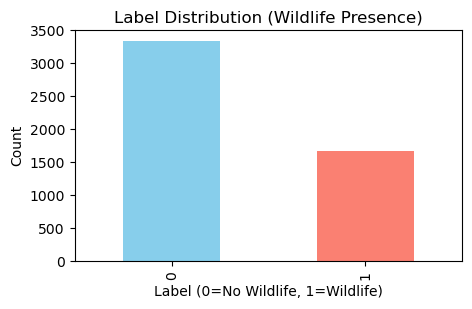

Method 1: value_counts() gives absolute numbers.
Method 2: value_counts(normalize=True) gives percentages.
Method 3: Bar plot visualizes the imbalance.


In [5]:
# Check for imbalance in the label column
label_counts = df_imputed['label'].value_counts()
label_percent = df_imputed['label'].value_counts(normalize=True) * 100
print("Label counts:")
print(label_counts)
print("\nLabel percentages:")
print(label_percent)

# Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
label_counts.plot(kind='bar', color=['skyblue','salmon'])
plt.title('Label Distribution (Wildlife Presence)')
plt.xlabel('Label (0=No Wildlife, 1=Wildlife)')
plt.ylabel('Count')
plt.show()

# Method comparison summary
print("Method 1: value_counts() gives absolute numbers.")
print("Method 2: value_counts(normalize=True) gives percentages.")
print("Method 3: Bar plot visualizes the imbalance.")

### EDA Step 2: Handling Moderate Class Imbalance
- With ~33% positives, imbalance is moderate, not severe. 
- Heavy resampling is not required.
- These steps help ensure reliable detection of wildlife without overfitting to the majority class.

### EDA Step 3: Summary Statistics and Feature Analysis
- We will use `.describe()` to get summary statistics for feature columns c1–c135.
- We will check for constant features (zero variance) and outliers/skewness using min, max, and std.
- Based on the results, we may consider normalization or removal of problematic features before modeling.

In [6]:
# Summary statistics for feature columns c1–c135
feature_cols = [f'c{i}' for i in range(1, 136)]
desc = df_imputed[feature_cols].describe().T
#print(desc)

# Identify constant features (zero variance)
constant_features = desc[desc['std'] == 0].index.tolist()
print('Constant features:', constant_features)

# Identify features with high skewness or outliers
skewness = df_imputed[feature_cols].skew()
high_skew = skewness[abs(skewness) > 2].index.tolist()
print('Highly skewed features (|skew| > 2):', high_skew)

Constant features: []
Highly skewed features (|skew| > 2): ['c1', 'c2', 'c7', 'c8', 'c9', 'c10', 'c15', 'c16', 'c17', 'c21', 'c22', 'c23', 'c24', 'c27', 'c30', 'c33', 'c45', 'c72', 'c75', 'c84', 'c85', 'c86', 'c87', 'c88', 'c89', 'c90', 'c91', 'c92', 'c93', 'c94', 'c95', 'c96', 'c97', 'c98', 'c99', 'c100', 'c106', 'c109', 'c112', 'c118', 'c122', 'c123', 'c127', 'c128', 'c129']


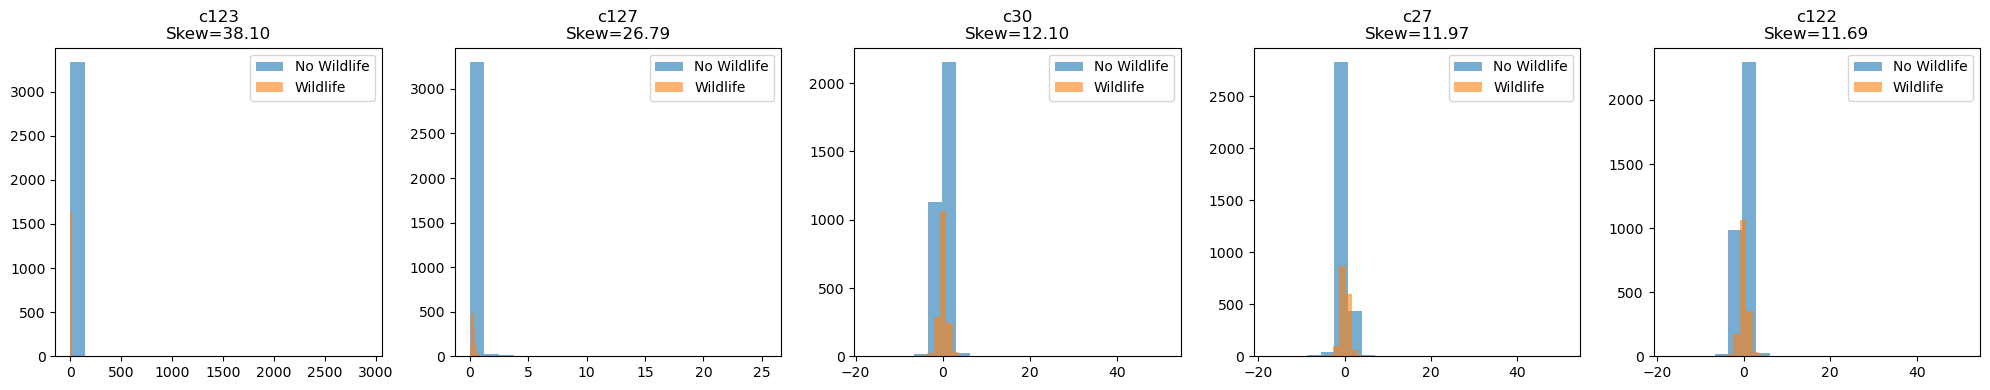

In [7]:
# Plot histograms for the top 5 most highly skewed features (by absolute skewness)
import matplotlib.pyplot as plt
feature_cols = [f'c{i}' for i in range(1, 136)]
skewness = df_imputed[feature_cols].skew().abs()
top_skewed = skewness.sort_values(ascending=False).head(5).index.tolist()
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, feat in enumerate(top_skewed):
    axes[i].hist(df_imputed[df_imputed['label'] == 0][feat], bins=20, alpha=0.6, label='No Wildlife')
    axes[i].hist(df_imputed[df_imputed['label'] == 1][feat], bins=20, alpha=0.6, label='Wildlife')
    axes[i].set_title(f"{feat}\nSkew={skewness[feat]:.2f}")
    axes[i].legend()
plt.tight_layout()
plt.show()

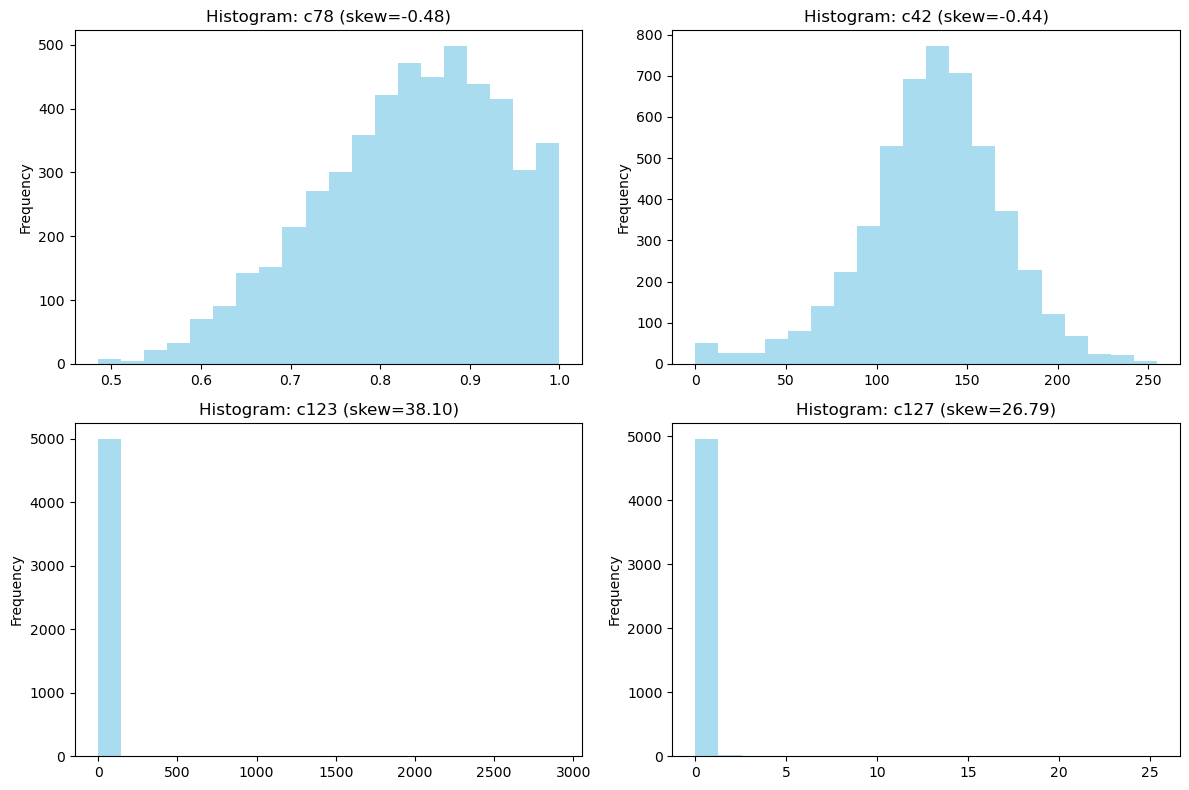

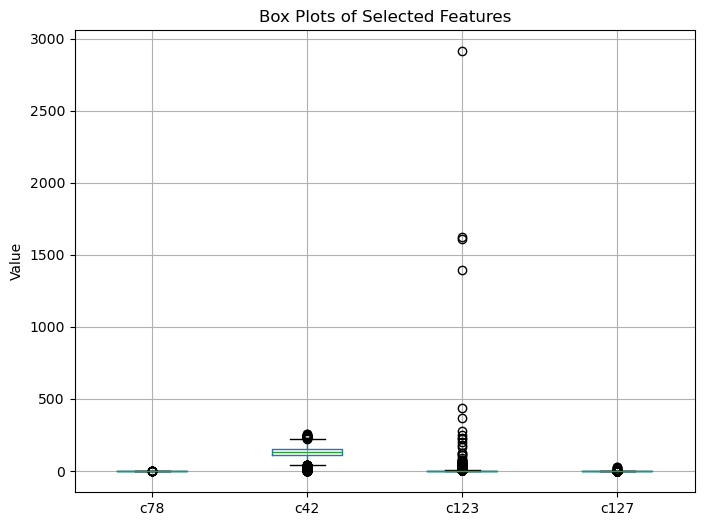

Feature: c78
  Skewness: -0.48
  Histogram shows symmetric distribution.
  Box plot shows median, quartiles, and outliers.

Feature: c42
  Skewness: -0.44
  Histogram shows symmetric distribution.
  Box plot shows median, quartiles, and outliers.

Feature: c123
  Skewness: 38.10
  Histogram shows skewed distribution.
  Box plot shows median, quartiles, and outliers.

Feature: c127
  Skewness: 26.79
  Histogram shows skewed distribution.
  Box plot shows median, quartiles, and outliers.



In [8]:
# Select 2 not skewed and 2 highly skewed features
import matplotlib.pyplot as plt
feature_cols = [f'c{i}' for i in range(1, 136)]
skewness = df_imputed[feature_cols].skew()
not_skewed = skewness[abs(skewness) < 0.5].sort_values().head(2).index.tolist()
highly_skewed = skewness[abs(skewness) > 2].sort_values(ascending=False).head(2).index.tolist()
selected_features = not_skewed + highly_skewed

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, feat in enumerate(selected_features):
    # Histogram
    axes[i//2, i%2].hist(df_imputed[feat], bins=20, color='skyblue', alpha=0.7)
    axes[i//2, i%2].set_title(f"Histogram: {feat} (skew={skewness[feat]:.2f})")
    axes[i//2, i%2].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
df_imputed[selected_features].boxplot()
plt.title('Box Plots of Selected Features')
plt.ylabel('Value')
plt.show()

# Analysis
for feat in selected_features:
    print(f"Feature: {feat}")
    print(f"  Skewness: {skewness[feat]:.2f}")
    print(f"  Histogram shows {'symmetric' if abs(skewness[feat]) < 0.5 else 'skewed'} distribution.")
    print(f"  Box plot shows median, quartiles, and outliers.\n")

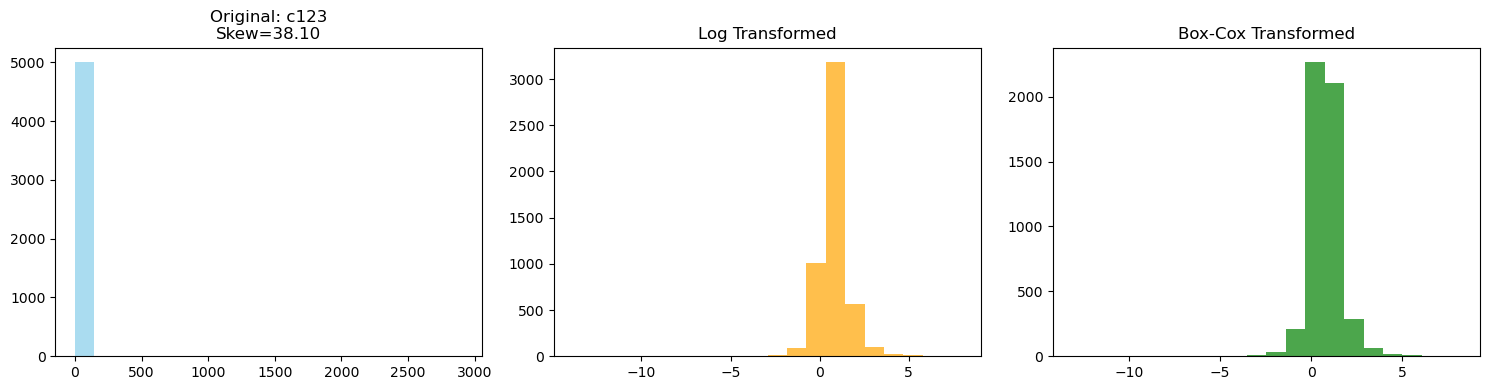

Original skewness: 38.10
Log transformed skewness: -0.20
Box-Cox transformed skewness: 0.05


In [9]:
# Demonstrate skew reduction using Log and Box-Cox transformations
from scipy.stats import boxcox
import numpy as np
import matplotlib.pyplot as plt

# Select a highly skewed feature
given_feature = None
feature_cols = [f'c{i}' for i in range(1, 136)]
skewness = df_imputed[feature_cols].skew()
highly_skewed = skewness[abs(skewness) > 2].sort_values(ascending=False)
if not highly_skewed.empty:
    given_feature = highly_skewed.index[0]
else:
    given_feature = feature_cols[0]  # fallback

# Prepare data (shift if needed for log/boxcox)
feat_data = df_imputed[given_feature]
if (feat_data <= 0).any():
    shift = abs(feat_data.min()) + 1e-6
    feat_data_shifted = feat_data + shift
else:
    feat_data_shifted = feat_data

# Log transformation
log_transformed = np.log(feat_data_shifted)
# Box-Cox transformation
boxcox_transformed, _ = boxcox(feat_data_shifted)

# Plot original and transformed distributions
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.hist(feat_data, bins=20, color='skyblue', alpha=0.7)
plt.title(f'Original: {given_feature}\nSkew={skewness[given_feature]:.2f}')
plt.subplot(1, 3, 2)
plt.hist(log_transformed, bins=20, color='orange', alpha=0.7)
plt.title('Log Transformed')
plt.subplot(1, 3, 3)
plt.hist(boxcox_transformed, bins=20, color='green', alpha=0.7)
plt.title('Box-Cox Transformed')
plt.tight_layout()
plt.show()

print(f"Original skewness: {skewness[given_feature]:.2f}")
print(f"Log transformed skewness: {pd.Series(log_transformed).skew():.2f}")
print(f"Box-Cox transformed skewness: {pd.Series(boxcox_transformed).skew():.2f}")

In [11]:
# Identify features with almost normal distribution
import matplotlib.pyplot as plt
from scipy.stats import normaltest
feature_cols = [f'c{i}' for i in range(1, 136)]
skewness = df_imputed[feature_cols].skew()
kurtosis = df_imputed[feature_cols].kurt()

# Criteria: low skewness, kurtosis near 0, normaltest p-value > 0.05
normal_like = []
for feat in feature_cols:
    stat, p = normaltest(df_imputed[feat].dropna())
    if abs(skewness[feat]) < 0.3 and abs(kurtosis[feat]) < 1 and p > 0.05:
        normal_like.append(feat)

print('Features with almost normal distribution:', normal_like)
# Show evidence for up to 2 such features
for feat in normal_like[:2]:
    plt.figure(figsize=(6,4))
    plt.hist(df_imputed[feat], bins=20, color='skyblue', alpha=0.7, density=True)
    plt.title(f'Histogram: {feat} (skew={skewness[feat]:.2f}, kurt={kurtosis[feat]:.2f})')
    # Overlay normal curve
    from scipy.stats import norm
    mu, std = df_imputed[feat].mean(), df_imputed[feat].std()
    x = np.linspace(mu-3*std, mu+3*std, 100)
    plt.plot(x, norm.pdf(x, mu, std), 'r-', lw=2, label='Normal PDF')
    plt.legend()
    plt.show()
    stat, p = normaltest(df_imputed[feat].dropna())
    print(f"Feature: {feat}")
    print(f"  Skewness: {skewness[feat]:.2f}")
    print(f"  Kurtosis: {kurtosis[feat]:.2f}")
    print(f"  Normaltest p-value: {p:.3f}")
    print(f"  Evidence: Histogram matches normal curve, skewness and kurtosis near 0, normaltest not significant.\n")
if not normal_like:
    print("No features found with almost normal distribution by these criteria.")

Features with almost normal distribution: []
No features found with almost normal distribution by these criteria.


Features with approximately normal distribution (relaxed criteria):
['c46']


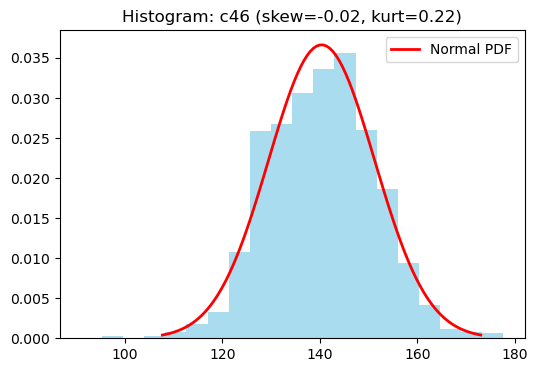

Feature: c46
  Skewness: -0.02
  Kurtosis: 0.22
  Normaltest p-value: 0.013
  Evidence: Histogram matches normal curve, metrics close to normal.



In [13]:
# Find features with approximately normal distribution
from scipy.stats import normaltest
feature_cols = [f'c{i}' for i in range(1, 136)]
skewness = df_imputed[feature_cols].skew()
kurtosis = df_imputed[feature_cols].kurt()

approx_normal = []
for feat in feature_cols:
    data = df_imputed[feat].dropna()
    stat, p = normaltest(data)
    # Relaxed criteria: skewness < 0.5, kurtosis < 2, p > 0.01
    if abs(skewness[feat]) < 0.5 and abs(kurtosis[feat]) < 2 and p > 0.01:
        approx_normal.append(feat)

print("Features with approximately normal distribution (relaxed criteria):")
print(approx_normal)

# Show histograms for up to 3 such features
import matplotlib.pyplot as plt
from scipy.stats import norm
for feat in approx_normal[:3]:
    data = df_imputed[feat].dropna()
    plt.figure(figsize=(6,4))
    plt.hist(data, bins=20, color='skyblue', alpha=0.7, density=True)
    mu, std = data.mean(), data.std()
    x = np.linspace(mu-3*std, mu+3*std, 100)
    plt.plot(x, norm.pdf(x, mu, std), 'r-', lw=2, label='Normal PDF')
    plt.title(f'Histogram: {feat} (skew={skewness[feat]:.2f}, kurt={kurtosis[feat]:.2f})')
    plt.legend()
    plt.show()
    stat, p = normaltest(data)
    print(f"Feature: {feat}")
    print(f"  Skewness: {skewness[feat]:.2f}")
    print(f"  Kurtosis: {kurtosis[feat]:.2f}")
    print(f"  Normaltest p-value: {p:.3f}")
    print(f"  Evidence: Histogram matches normal curve, metrics close to normal.\n")